# Bulding the Rydberg Hamiltonian

This notebook contains the code and data to generate the results for the first part of the paper. This includes only classical stuff.

Structure of the notebook:
- [Build the material structure](#build_material)
- [Build the test/test set](#test_test)
- [Write CRYSTAL input files](#write_input)
- [Read CRYSTAL output files](#read_output)
- [Mapping to the Rydberg Hamiltonian](#mapping_to_ryd)
- [Approximations](#approximations)
- [Compare to QUBO model](#QUBO)
- [Classical Monte Carlo](#monte_carlo)

In [141]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import minimize
from scipy import constants

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import cut_graphene_rectangle
from random_structures import *
from QUBO_models import *

import json
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the Material Structure
<a id="build_material"></a>

This section will focus on building the material structure, including relevant parameters and visualizations.

In [5]:
# Add the pymatgen structure here

In [3]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])

graphene_mol_r_6_6 = cut_graphene_rectangle(graphene,15,14,center=True)
graphene_mol_r_6_6.remove_sites([1,5,11,18,25,32])
vview(graphene_mol_r_6_6)

Add periodic boundary conditions

In [3]:
cell = np.array([[16.04, -2.134, 0.0],
                [ 0.0, 12.8 ,0.0],
                [0.0, 0.0, 10.0]])
graphene_mol_r_6_6_pbc = Structure(cell, graphene_mol_r_6_6.atomic_numbers, 
                                   graphene_mol_r_6_6.cart_coords, coords_are_cartesian=True)

vview(graphene_mol_r_6_6_pbc)

## Build the Test/test Set
<a id="test_test"></a>

In this section, we'll create the test and train datasets using the prepared material structure.

In [4]:
atom_indices = get_all_configurations(graphene_mol_r_6_6_pbc)

binary_an = []

for n,i in enumerate(np.arange(1,11,1)):
    
    active_sites = np.where(np.array(graphene_mol_r_6_6_pbc.atomic_numbers)==6)[0]
    N_atoms = i
    
    structures_random = generate_random_structures(graphene_mol_r_6_6_pbc,atom_indices=atom_indices,
                                                       N_atoms=N_atoms,
                                                       new_species=7,N_config=100,DFT_config=10,
                                                       return_multiplicity=False,
                                                       active_sites=active_sites)
    # print(i,len(structures_random))

    num_structures = len(structures_random)
    
    for structure in structures_random:
        binary_an_tmp = np.zeros(len(active_sites),dtype='int')
        binary_an_tmp[np.where(np.array(structure.atomic_numbers) == 7)[0]] = 1
        binary_an.append(binary_an_tmp)

binary_an = np.array(binary_an)

# np.savetxt('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_test.csv',binary_an,delimiter=',',fmt='%d')

## Write CRYSTAL Input Files
<a id="write_input"></a>

Here, we will generate the input files for the CRYSTAL simulation using the defined structure and parameters.

### Train set

In [ ]:
import copy
import shutil as sh
import numpy as np

# TRAIN
# Load the input template and indices
with open('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_train.csv',
    delimiter=','
).astype(int)

# Iterate over the training indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/pbc/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.d12'
    gui_filename = f'data/crystal/graphene/pbc/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.gui'

    # Write the modified template to the output file
    with open(d12_filename, 'w') as file:
        file.writelines(input_template)

    # Copy the GUI file to the output directory
    sh.copy(
        './data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui',
        gui_filename
    )

    # Print the command for running the script
#  print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 10} &')

### Test set

In [ ]:
import copy
import shutil as sh
import numpy as np

# Test
# Load the input template and indices
with open('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_test.csv',
    delimiter=','
).astype(int)

# Iterate over the testing indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/pbc/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.d12'
    gui_filename = f'data/crystal/graphene/pbc/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.gui'

    # Write the modified template to the output file
    with open(d12_filename, 'w') as file:
        file.writelines(input_template)

    # Run the following only to generate the input files, then use the
    # ones generated by the calculation
    
    # # Copy the GUI file to the output directory
    # sh.copy(
    #     './data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui',
    #     gui_filename
    # )

    # Print the command for running the script
#  print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 10} &')

## Read CRYSTAL Output Files
<a id="read_output"></a>

This section covers how to parse and interpret the output files produced by the CRYSTAL simulation.

In [4]:
import os
import numpy as np

N_atom = 7
N_sites = 78

train_folder = 'data/crystal/graphene/pbc/train_set/'
test_folder = 'data/crystal/graphene/pbc/test_set/'

def extract_final_energy(file_path):
    """
    Extract the final energy from a CRYSTAL output file.

    Parameters:
        file_path (str): Path to the .out file.

    Returns:
        float: Final energy in atomic units (AU) or None if not found.
    """
    with open(file_path, 'r') as f:
        for line in f:
            if '* OPT END - CONVERGED' in line:
                # Extract the energy from the line
                parts = line.split()
                return float(parts[7])  # Energy is the 7th element in the line
    return None

from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice

def read_gui_file(file_path):
    """
    Reads a .gui file and creates a pymatgen Structure object.
    
    Parameters:
        file_path (str): Path to the .gui file.
    
    Returns:
        pymatgen.core.structure.Structure: Pymatgen Structure object.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Parse lattice matrix (lines 2-4)
    lattice = []
    for i in range(1, 4):
        lattice.append([float(x) for x in lines[i].split()])

    # Skip symmetry operators
    num_symmetry_operators = int(lines[4].strip())
    start_index = 5 + 4 * num_symmetry_operators

    # Parse number of atoms
    num_atoms = int(lines[start_index].strip())
    start_index += 1

    # Parse atomic positions and numbers
    atomic_numbers = []
    cartesian_coords = []
    for i in range(start_index, start_index + num_atoms):
        parts = lines[i].split()
        atomic_numbers.append(int(parts[0]))  # Atomic number
        cartesian_coords.append([float(x) for x in parts[1:4]])  # Cartesian coordinates

    # Create and return the pymatgen Structure object
    lattice_matrix = Lattice(lattice)
    structure = Structure(
        lattice_matrix,
        atomic_numbers,
        cartesian_coords,
        coords_are_cartesian=True
    )
    return structure

def process_files(folder, structures, energies):
    """
    Process CRYSTAL .out files in a folder to extract structures and normalized energies.

    Parameters:
        folder (str): Path to the folder containing .out files.
        structures (list): List to store extracted structures.
        energies (list): List to store extracted normalized energies.
    """
    for file in os.listdir(folder):
        if file.endswith('.out'):
            file_name = file[:-4]
            file_path = os.path.join(folder, file)

            # Extract the final energy
            energy = extract_final_energy(file_path)
            if energy is None:
                continue  # Skip files without valid energy
            
            # Read the GUI file for the structure
            gui_file_path = os.path.join(folder, file_name + '.gui')
            structure = read_gui_file(gui_file_path)

            # Append structure to the list
            structures.append(structure)

            # Calculate normalized energy
            N_N = np.sum(np.array(structure.atomic_numbers) == 7)
            N_C = N_sites - N_N
            energy_norm = (energy - (E_C * N_C) - (E_N * N_N)) / N_sites
            energies.append(energy_norm)
            # energies.append(energy)

E_N = extract_final_energy('../QA_solid_solutions/data/crystal/graphene/N2.out')/2
E_C = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')/78
E_graphene = extract_final_energy(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')


# Process training set
structures_train = []
energies_train = []
process_files(train_folder, structures_train, energies_train)

# Process test set
structures_test = []
energies_test = []
process_files(test_folder, structures_test, energies_test)

## Mapping to the Rydberg Hamiltonian
<a id="mapping_to_ryd"></a>

We'll map the results from CRYSTAL simulations to the Rydberg Hamiltonian in this section.

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np

def build_H_ryd(structure, binary_occ, energies, neighbor_counts, scaling_factors):
    """
    Build a QUBO matrix using machine learning based on a structure and training data.

    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        binary_occ (list of np.ndarray): List of training configurations.
        energies (np.ndarray): Training target energies.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: QUBO matrix.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    # Sort the distance matrix and get sorted indices
    sorted_indices = np.argsort(distance_matrix, axis=1)
    sorted_distances = np.sort(distance_matrix, axis=1)

    # Initialize filtered distance matrix
    distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # Assign scaling factors based on the number of neighbors per shell
    for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
        start_idx = 0
        for shell_idx, num_neighbors in enumerate(neighbor_counts):
            # Determine the indices for this shell
            end_idx = start_idx + num_neighbors
            neighbors = site_indices[start_idx:end_idx]  # Select neighbors
            distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
            start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)
 
    # Step 2: Build the descriptor for the training set
    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in binary_occ:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)
        
        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Descriptor includes the number of occupied sites and sum of selected elements
        num_occupied_sites = np.sum(config)
        descriptor.append([num_occupied_sites, np.sum(selected_elements)])

    descriptor = np.array(descriptor)

    # Step 3: Train a linear regression model
    reg = LinearRegression()
    reg.fit(descriptor, energies)

    # Print R^2 score
    print(f"R²: {reg.score(descriptor, energies):.4f}")


    return reg.coef_

In [7]:
import numpy as np

def calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors):
    """
    Calculate the energy for test configurations using the regression coefficients and neighbor contributions.

    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        X_test (list of np.ndarray): Test configurations.
        reg_coef (np.ndarray): Regression coefficients from the linear model.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: Calculated energies for the test configurations.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    # Sort the distance matrix and get sorted indices
    sorted_indices = np.argsort(distance_matrix, axis=1)
    sorted_distances = np.sort(distance_matrix, axis=1)

    # Initialize filtered distance matrix
    distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # Assign scaling factors based on the number of neighbors per shell
    for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
        start_idx = 0
        for shell_idx, num_neighbors in enumerate(neighbor_count):
            # Determine the indices for this shell
            end_idx = start_idx + num_neighbors
            neighbors = site_indices[start_idx:end_idx]  # Select neighbors
            distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
            start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)

    # Step 2: Calculate the energy contributions for each test configuration
    energies = []
    for config in X_test:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)

        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Calculate the energy contribution
        num_occupied_sites = np.sum(config)  # Contribution from the number of occupied sites
        pairwise_contribution = np.sum(selected_elements * reg_coef[1])  # Contribution from neighbors

        # Add all contributions
        energy = reg_coef[0] * num_occupied_sites + pairwise_contribution
        energies.append(energy)

    return np.array(energies)

In [433]:
import numpy as np

def calculate_Ryd_energy_mol(structure, X_test, reg_coef, scaling_factors):
    """
    Calculate the energy for test configurations using the regression coefficients and neighbor contributions.
    For the non periodic structure
    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        X_test (list of np.ndarray): Test configurations.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: Calculated energies for the test configurations.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    structure = Molecule(structure.atomic_numbers,structure.cart_coords)
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    num_sites = structure.num_sites
    distance_matrix_mol = np.round(structure.distance_matrix, 5)

    # Initialize an empty distance matrix
    distance_matrix_filter = np.zeros((num_sites, num_sites), dtype=float)

    # Get unique distance shells and limit to the maximum number of neighbors
    shells = np.unique(distance_matrix_mol)
    max_neigh = len(scaling_factors)

    # Assign scaled values to the distance matrix based on shells
    for i, shell in enumerate(shells[:max_neigh]):
        # print(i,shell,scaling_factors[i])
        # Find row and column indices where the distance matches the current shell
        row_indices, col_indices = np.where(distance_matrix_mol == shell)
        
        # Apply the scaling factor to the corresponding entries
        distance_matrix_filter[row_indices, col_indices] = scaling_factors[i]

    # # Sort the distance matrix and get sorted indices
    # sorted_indices = np.argsort(distance_matrix, axis=1)
    # sorted_distances = np.sort(distance_matrix, axis=1)

    # # Initialize filtered distance matrix
    # distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # # Assign scaling factors based on the number of neighbors per shell
    # for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
    #     start_idx = 0
    #     for shell_idx, num_neighbors in enumerate(neighbor_count):
    #         # Determine the indices for this shell
    #         end_idx = start_idx + num_neighbors
    #         neighbors = site_indices[start_idx:end_idx]  # Select neighbors
    #         distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
    #         start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)
    
    # Step 2: Calculate the energy contributions for each test configuration
    energies = []
    for config in X_test:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)

        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Calculate the energy contribution
        num_occupied_sites = np.sum(config)  # Contribution from the number of occupied sites
        pairwise_contribution = np.sum(selected_elements * reg_coef[1])  # Contribution from neighbors

        # Add all contributions
        energy = reg_coef[0] * num_occupied_sites + pairwise_contribution
        energies.append(energy)

    return np.array(energies)

In [432]:

calculate_Ryd_energy_mol(structure, binary_vector_all[0:1], [0.,(C6/(4.1e-6**6))/eV_to_rad_s], [0,1,1/27,1/343])

array([4.89624766e-05])

In [408]:
vview(structure)

2025-04-15 17:27:00.049 python[72296:27847089] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-15 17:27:00.049 python[72296:27847089] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [62]:
neighbor_count = [3,6,3]
scaling_factors = [1,1/27,1/343]
structure = read_gui_file('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui')
structure = SpacegroupAnalyzer(structure).get_symmetrized_structure()
atom_indices_graphene = get_all_configurations(structure)
N_atom = 7

num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene,N_atom)

reg_coef = build_H_ryd(structure, X_train, y_train, neighbor_count, scaling_factors)

y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)

R²: 0.9473


In [63]:
reg_coef

array([0.00030122, 0.00020351])

#### Periodic

In [11]:
from sklearn.metrics import mean_squared_error

# Calculate the predicted energies
y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

from scipy.stats import spearmanr

# Calculate Spearman's rank correlation coefficient
rho, p_value = spearmanr(y_pred, y_test)

# Output results
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho}")
print(f"P-value: {p_value}")

Mean Squared Error (MSE): 9.842369374561389e-08
Spearman's Rank Correlation Coefficient (ρ): 0.9765413451575011
P-value: 0.0


#### Molecule

In [12]:
from sklearn.metrics import mean_squared_error

# Calculate the predicted energies
y_pred = calculate_Ryd_energy_mol(structure, X_test, reg_coef, scaling_factors)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

from scipy.stats import spearmanr

# Calculate Spearman's rank correlation coefficient
rho, p_value = spearmanr(y_pred, y_test)

# Output results
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho}")
print(f"P-value: {p_value}")

Mean Squared Error (MSE): 9.255548737162568e-08
Spearman's Rank Correlation Coefficient (ρ): 0.9719555410609754
P-value: 0.0


### Energy to R

In [13]:
# Given values
C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.5193e+15  # Conversion factor for eV to rad/s
coulomb_interaction = reg_coef[1] * eV_to_rad_s  # Calculate coulomb interaction

# Calculate R
R = (C6 / coulomb_interaction) ** (1 / 6)  # R in meters

# Convert R to micrometers (1 meter = 1e6 micrometers)
R_micrometers = R * 1e6

# Print R in micrometers
print(f"R in micrometers: {R_micrometers:.6f} µm")

R in micrometers: 1.611742 µm


In [14]:
# If I want to keep the same ratio I get in the QUBO mapping

# Given values
C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.5193e+15  # Conversion factor for eV to rad/s
coulomb_interaction = reg_coef[1]/(reg_coef[0]/(125000000 / eV_to_rad_s)) * eV_to_rad_s  # Calculate coulomb interaction

# Calculate R
R = (C6 / coulomb_interaction) ** (1 / 6)  # R in meters

# Convert R to micrometers (1 meter = 1e6 micrometers)
R_micrometers = R * 1e6

# Print R in micrometers
print(f"R in micrometers: {R_micrometers:.6f} µm")

R in micrometers: 6.327511 µm


## Revelation

In [213]:
# REVELATION R=2um
V_2um = (C6/(4e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um
print(f"V_ratio={V_ratio}")

Delta_g_hardware_max = 125000000
print(f"Delta_g_hardware_max={Delta_g_hardware_max:.3e}")
# for Delta_g_hardware in np.linspace(-125000000*2,-125000000,10,endpoint=True):
Delta_g_qubo = reg_coef[0]*eV_to_rad_s
print(f"Delta_g_qubo={Delta_g_qubo:.3e}")
Delta_g_2um = Delta_g_qubo/V_ratio
print(f"Delta_g_2um={Delta_g_2um:.3e}")
Delta_mu = Delta_g_2um-Delta_g_hardware_max # This is the difference between the value I would need to map the problem correctly and what I have in the annealer
print(f"Delta_mu={Delta_mu:.3e}")
# I think the Delta_mu should be negative
reg_coef[0] + Delta_mu/eV_to_rad_s
# print(Delta_g_hardware,reg_coef[0] +(Delta_mu+Delta_g_hardware)/eV_to_rad_s)


V_ratio=233.6611304636894
Delta_g_hardware_max=1.250e+08
Delta_g_qubo=4.577e+11
Delta_g_2um=1.959e+09
Delta_mu=1.834e+09


np.float64(0.0003024313488454176)

In [116]:
# REVELATION Delta_g = 125000000

Delta_g_hardware_max = 125000000
print(f"Delta_g_hardware_max={Delta_g_hardware_max:.3e},Delta_g_hardware_max eV Delta_g={Delta_g_hardware_max/eV_to_rad_s:.3e}")
print()

Delta_g_effective_all = []
Delta_mu_rad_s_hardware_all = []
Delta_mu_eV_scaled_all = []
Delta_g_hardware_all = []

Delta_g_ratio = reg_coef[0]*eV_to_rad_s/Delta_g_hardware_max

Delta_g_hardware_range = np.linspace(-125000000*2,0,10,endpoint=True)
for Delta_g_hardware in Delta_g_hardware_range:
# for Delta_g_hardware in [0]:
    
    Delta_g_hardware_all.append(1.25e8+Delta_g_hardware)
    # print(f"Delta_g_ratio={Delta_g_ratio}")
    # Delta_g_effective = (reg_coef[0]*eV_to_rad_s/Delta_g_ratio)+Delta_g_hardware
    print(f"Delta_g_hardware={Delta_g_hardware:.3e} rad/s, Delta_g_hardware={Delta_g_hardware/eV_to_rad_s:.3e} eV")
    
    Delta_mu_rescaled = Delta_g_hardware*Delta_g_ratio
    Delta_mu_eV_scaled_all.append(Delta_mu_rescaled/eV_to_rad_s)
    print(f"Delta_mu_rescaled={Delta_mu_rescaled:.3e} rad/s, Delta_mu_rescaled={Delta_mu_rescaled/eV_to_rad_s:.3e} eV")
    
    Delta_g_effective = Delta_g_hardware_max-Delta_g_hardware
    print(f"Delta_g_effective={Delta_g_effective:.3e} rad/s, Delta_g_effective={Delta_g_effective/eV_to_rad_s:.3e} eV")
    
    Delta_g_effective_rescaled = (Delta_g_hardware_max+Delta_g_hardware)*Delta_g_ratio
    print(f"Delta_g_effective_rescaled={Delta_g_effective_rescaled:.3e} rad/s, Delta_g_effective_rescaled={Delta_g_effective_rescaled/eV_to_rad_s:.3e} eV")

    print()

    


Delta_g_hardware_max=1.250e+08,Delta_g_hardware_max eV Delta_g=8.227e-08

Delta_g_hardware=-2.500e+08 rad/s, Delta_g_hardware=-1.645e-07 eV
Delta_mu_rescaled=-9.153e+11 rad/s, Delta_mu_rescaled=-6.024e-04 eV
Delta_g_effective=3.750e+08 rad/s, Delta_g_effective=2.468e-07 eV
Delta_g_effective_rescaled=-4.577e+11 rad/s, Delta_g_effective_rescaled=-3.012e-04 eV

Delta_g_hardware=-2.222e+08 rad/s, Delta_g_hardware=-1.463e-07 eV
Delta_mu_rescaled=-8.136e+11 rad/s, Delta_mu_rescaled=-5.355e-04 eV
Delta_g_effective=3.472e+08 rad/s, Delta_g_effective=2.285e-07 eV
Delta_g_effective_rescaled=-3.560e+11 rad/s, Delta_g_effective_rescaled=-2.343e-04 eV

Delta_g_hardware=-1.944e+08 rad/s, Delta_g_hardware=-1.280e-07 eV
Delta_mu_rescaled=-7.119e+11 rad/s, Delta_mu_rescaled=-4.686e-04 eV
Delta_g_effective=3.194e+08 rad/s, Delta_g_effective=2.103e-07 eV
Delta_g_effective_rescaled=-2.543e+11 rad/s, Delta_g_effective_rescaled=-1.673e-04 eV

Delta_g_hardware=-1.667e+08 rad/s, Delta_g_hardware=-1.097e-07 eV

[np.float64(-125000000.0), np.float64(-97222222.22222221), np.float64(-69444444.44444445), np.float64(-41666666.66666669), np.float64(-13888888.888888896), np.float64(13888888.888888896), np.float64(41666666.66666666), np.float64(69444444.44444442), np.float64(97222222.22222221), np.float64(125000000.0)]
[np.float64(-0.0006024489452176543), np.float64(-0.0005355101735268037), np.float64(-0.00046857140183595333), np.float64(-0.0004016326301451029), np.float64(-0.0003346938584542524), np.float64(-0.00026775508676340186), np.float64(-0.00020081631507255145), np.float64(-0.000133877543381701), np.float64(-6.69387716908505e-05), np.float64(0.0)]


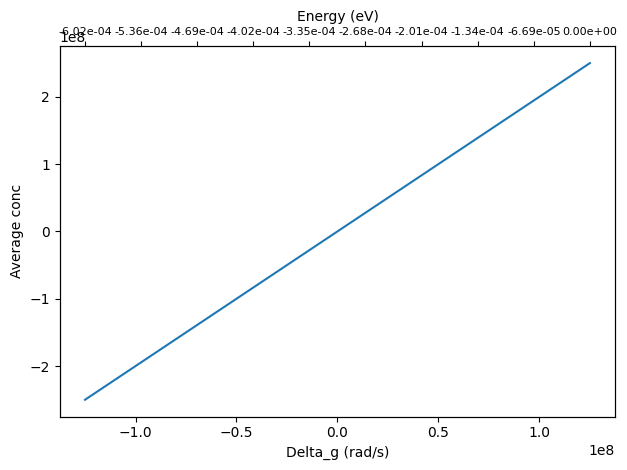

In [132]:
x = np.array(Delta_g_hardware_all)  # wavelength in nm
y = 2*x  # fake spectrum

fig, ax_bottom = plt.subplots()
ax_bottom.plot(x, y)
ax_bottom.set_xlabel('Delta_g (rad/s)')
ax_bottom.set_ylabel('Average conc')

# Top axis: energy in eV
ax_top = ax_bottom.twiny()

# Sync bottom and top axis limits
ax_top.set_xlim(ax_bottom.get_xlim())

# Set custom ticks based on energy
Delta_g_hardware_ticks = copy.deepcopy(Delta_g_hardware_all[::])
print(Delta_g_hardware_ticks)
Delta_mu_ticks = [x*Delta_g_ratio/eV_to_rad_s for x in np.array(Delta_g_hardware_all[::])-1.25e8]
print(Delta_mu_ticks)

ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks],fontsize=8)
ax_top.set_xlabel("Energy (eV)")

plt.tight_layout()
plt.show()

In [182]:
reg_coef[1]

np.float64(0.00020350836925458785)

In [231]:
print(f"{4.5765034123e+11*V_ratio/eV_to_rad_s:.10e}")

7.0384450792e-02


In [234]:
print(f"{0.00020351:.10e}")

2.0351000000e-04


In [ ]:
-1.9585779847\times10^{9}  -1.25\times10^{8}

In [248]:
a = reg_coef[0]-3.2044440684e-04
print(f"{a:.10e}")

-1.9219934231e-05


In [271]:
V_2um/eV_to_rad_s

8.709551684986508e-07

In [276]:
(C6/(4.1e-6**6))/eV_to_rad_s

7.510219121884898e-07

In [365]:
V_ratio

np.float64(233.6611304636894)

In [366]:
# REVELATION R=2um
V_2um = (C6/(4e-6**6))
V_qubo = reg_coef[1]*eV_to_rad_s
V_ratio = V_qubo/V_2um

Delta_g_hardware_max = 125000000
print(f"Delta_g_hardware_max={Delta_g_hardware_max:.3e} = {Delta_g_hardware_max/eV_to_rad_s:.3e} eV") # This is the max I can use in the hardware

Delta_g_qubo = reg_coef[0]*eV_to_rad_s
print(f"Delta_g_qubo={Delta_g_qubo:.10e} rad/s = {Delta_g_qubo/eV_to_rad_s:.10e} eV") 

Delta_g_2um = Delta_g_qubo/V_ratio
print(f"Delta_g_2um={Delta_g_2um:.3e} rad/s ={Delta_g_2um/eV_to_rad_s:.3e} eV")

# When Delta_g == 0
Delta_g_scaled = Delta_g_hardware_max*V_ratio
print(f"Delta_g_scaled={Delta_g_scaled:.3e} rad/s = {Delta_g_scaled/eV_to_rad_s:.3e} eV ?????")
print()
Delta_mu_all = []
Delta_g_hardware_all = np.linspace(-125000000,125000000,10,endpoint=True)
for Delta_g_hardware in Delta_g_hardware_all:
    # print(f"Delta_g_hardware={Delta_g_hardware:.3e} rad/s = {Delta_g_hardware/eV_to_rad_s:.3e} eV")
    Delta_g_hardware_scaled = Delta_g_hardware*V_ratio
    # print(f"Delta_g_hardware_scaled={Delta_g_hardware_scaled:.3e} rad/s = {Delta_g_hardware_scaled/eV_to_rad_s:.3e} eV")
    Delta_mu = (-Delta_g_2um+Delta_g_hardware)*V_ratio # This is the Delta_mu relative to the original model the way I would calculate it in the D-Wave experiments
    # because I had to subtract the Delta_g_qubo to go to zero first and then the variation is only around that value
    Delta_mu_all.append(Delta_mu)
    print(f"Delta_g_hardware = {Delta_g_hardware:.3e},Delta_mu={Delta_mu:.3e} rad/s = {Delta_mu/eV_to_rad_s:.3e} eV")

# Delta_mu = Delta_g_2um-Delta_g_hardware_max # This is the difference between the value I would need to map the problem correctly and what I have in the annealer
# print(f"Delta_mu={Delta_mu:.3e} rad/s = {Delta_mu/eV_to_rad_s:.3e} eV")

# Now if I use Delta_g = 0 it's like I subtracted Q_ii scaled by the new value caused by the Rnn scaling V_ratio


# I think the Delta_mu should be negative
reg_coef[0] + Delta_mu/eV_to_rad_s
# print(Delta_g_hardware,reg_coef[0] +(Delta_mu+Delta_g_hardware)/eV_to_rad_s)


Delta_g_hardware_max=1.250e+08 = 8.227e-08 eV
Delta_g_qubo=4.5765034123e+11 rad/s = 3.0122447261e-04 eV
Delta_g_2um=1.959e+09 rad/s =1.289e-06 eV
Delta_g_scaled=2.921e+10 rad/s = 1.922e-05 eV ?????

Delta_g_hardware = -1.250e+08,Delta_mu=-4.869e+11 rad/s = -3.204e-04 eV
Delta_g_hardware = -9.722e+07,Delta_mu=-4.804e+11 rad/s = -3.162e-04 eV
Delta_g_hardware = -6.944e+07,Delta_mu=-4.739e+11 rad/s = -3.119e-04 eV
Delta_g_hardware = -4.167e+07,Delta_mu=-4.674e+11 rad/s = -3.076e-04 eV
Delta_g_hardware = -1.389e+07,Delta_mu=-4.609e+11 rad/s = -3.034e-04 eV
Delta_g_hardware = 1.389e+07,Delta_mu=-4.544e+11 rad/s = -2.991e-04 eV
Delta_g_hardware = 4.167e+07,Delta_mu=-4.479e+11 rad/s = -2.948e-04 eV
Delta_g_hardware = 6.944e+07,Delta_mu=-4.414e+11 rad/s = -2.905e-04 eV
Delta_g_hardware = 9.722e+07,Delta_mu=-4.349e+11 rad/s = -2.863e-04 eV
Delta_g_hardware = 1.250e+08,Delta_mu=-4.284e+11 rad/s = -2.820e-04 eV


np.float64(1.9224406837333764e-05)

[-1.25000000e+08 -9.72222222e+07 -6.94444444e+07 -4.16666667e+07
 -1.38888889e+07  1.38888889e+07  4.16666667e+07  6.94444444e+07
  9.72222222e+07  1.25000000e+08]
[np.float64(-0.0003204488794461609), np.float64(-0.0003161767890378645), np.float64(-0.0003119046986295681), np.float64(-0.0003076326082212717), np.float64(-0.00030336051781297536), np.float64(-0.00029908842740467896), np.float64(-0.00029481633699638256), np.float64(-0.00029054424658808616), np.float64(-0.00028627215617978976), np.float64(-0.00028200006577149336)]


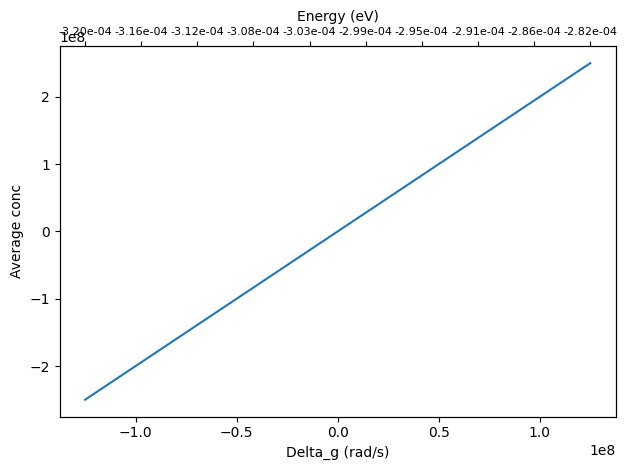

In [ ]:
# USE THIS FOR R=4um
Delta_g_hardware_all = np.linspace(-125000000,125000000,10,endpoint=True)
x = np.array(Delta_g_hardware_all)  # wavelength in nm
y = 2*x  # fake spectrum

fig, ax_bottom = plt.subplots()
ax_bottom.plot(x, y)
ax_bottom.set_xlabel('Delta_g (rad/s)')
ax_bottom.set_ylabel('Average conc')

# Top axis: energy in eV
ax_top = ax_bottom.twiny()

# Sync bottom and top axis limits
ax_top.set_xlim(ax_bottom.get_xlim())

# Set custom ticks based on energy
Delta_g_hardware_ticks = copy.deepcopy(Delta_g_hardware_all)
print(Delta_g_hardware_ticks)
Delta_mu_ticks = [(-Delta_g_qubo+Delta_g_hardware*V_ratio)/eV_to_rad_s for Delta_g_hardware in np.array(Delta_g_hardware_all)]
print(Delta_mu_ticks)

ax_top.set_xticks(Delta_g_hardware_ticks)
ax_top.set_xticklabels([f"{e:.2e}" for e in Delta_mu_ticks],fontsize=8)
ax_top.set_xlabel("Energy (eV)")

plt.tight_layout()
plt.show()

In [73]:
print(f"{1.25e8/eV_to_rad_s:.3e}")

8.227e-08


In [ ]:
print(f"{1.25e8/V_ratio:.3e}")

5.350e+05


In [75]:
print(f"{(C6/(4e-6**6))/eV_to_rad_s:.3e}")

8.710e-07


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (100).

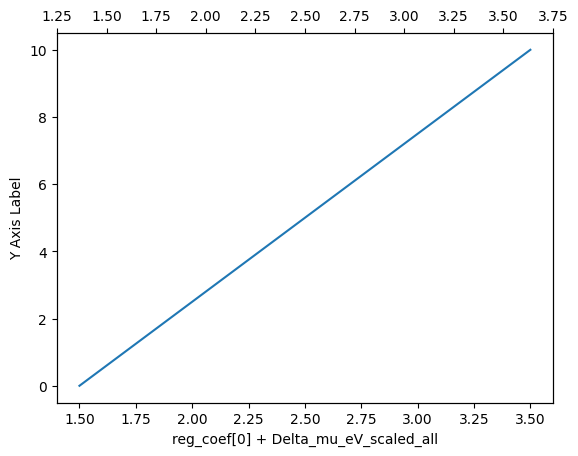

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
y = np.linspace(0, 10, 100)
# Delta_mu_eV_scaled_all = np.linspace(-1, 1, 100)
reg_coef = [2.5]  # Just an example coefficient
Delta_mu_rad_s_hardware_all = (reg_coef[0] + np.array(Delta_mu_eV_scaled_all) )  # Example transformation

# Create base plot with bottom x-axis
fig, ax1 = plt.subplots()

# Compute x-axis for bottom
x1 = reg_coef[0] + Delta_mu_eV_scaled_all
ax1.plot(x1, y, label="Main Curve")

ax1.set_xlabel("reg_coef[0] + Delta_mu_eV_scaled_all")
ax1.set_ylabel("Y Axis Label")

# Create top x-axis
ax2 = ax1.twiny()

# Set top axis to match the transformed data
x2 = Delta_mu_rad_s_hardware_all
ax2.set_xlim(ax1.get_xlim())  # Match bottom axis limits first
ax2.set_xticks(ax1.get_xticks())  # Sync ticks
ax2.set_xticklabels(np.round(x2, 2))  # Use the transformed values as labels
ax2.set_xlabel("Delta_mu_rad_s_hardware_all")

plt.tight_layout()
plt.show()

In [61]:
Delta_g_2um

np.float64(1958607066.251908)

In [62]:
Delta_mu/eV_to_rad_s

np.float64(1.2068762365904745e-06)

In [28]:
reg_coef[0]/(-125000000 / eV_to_rad_s)

np.float64(-3661.202729876729)

In [37]:
1958607066.251908/(-125000000 * eV_to_rad_s)

-1.0313207746998792e-14

In [1]:
(reg_coef[0]/233.6611304636894) * eV_to_rad_s

NameError: name 'reg_coef' is not defined

In [269]:
((C6/(4.1e-6**6))*(1/eV_to_rad_s))

7.510219121884898e-07

In [33]:
reg_coef[1]/((C6/(4e-6**6))*(1/eV_to_rad_s))

np.float64(233.6611304636894)

In [13]:
0.00030122*eV_to_rad_s

457643546000.0

## Approximations
<a id="approximations"></a>

This section discusses the approximations made in the mapping process and their implications.

## Compare to QUBO Model
<a id="QUBO"></a>

We'll compare the results of the Rydberg Hamiltonian mapping to the QUBO model.

## Classical Monte Carlo
<a id="monte_carlo"></a>

This section introduces classical Monte Carlo methods for validation and further analysis.

In [137]:
import numpy as np

def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels (in eV).
        multiplicity (np.ndarray): Array of corresponding multiplicities for energy levels.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Whether to return probabilities alongside the partition function. Default is True.
        N_N (float, optional): Number of N particles to consider. Default is 0.
        N_potential (float, optional): Potential energy contribution for N particles (in eV). Default is 0.

    Returns:
        tuple or float: 
            - If `return_pi` is True: Returns a tuple (partition function, probabilities).
            - If `return_pi` is False: Returns only the partition function.
    """
    # Constants
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K

    # Ensure inputs are NumPy arrays
    energy = np.array(energy, dtype=float)
    multiplicity = np.array(multiplicity, dtype=float)
    
    # Calculate the weighted probabilities for each energy level
    exponent = (-energy + (N_N * N_potential)) / (k_b * T)
    p_i = multiplicity * np.exp(exponent)
    
    # Compute the partition function
    pf = np.sum(p_i)
    
    # Normalize probabilities
    p_i /= pf
    
    # Return the results based on the flag
    if return_pi:
        return pf, p_i
    return pf

### New: hardware-energy to Delta mu mapping

In [302]:
# Write config-energies
structure = copy.deepcopy(graphene_mol_r_6_6)
Delta_mu_range = np.linspace(-reg_coef[0]*2,0,100)
size = 500000
neighbor_count = [3,6,3]
scaling_factors = [1,1/27,1/343]
binary_vector_all = []
Ryd_classical_E = []
concentration = []
N_positions = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites

T_all = [10]

concentration = np.random.randint(0, max_conc, size=size)

# global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x.tolist())
    N_positions.append(ones.tolist())

Ryd_classical_E = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, [0.,reg_coef[1]], neighbor_count, scaling_factors
)

data = {
    "N_positions": N_positions,
    "Ryd_classical_E": Ryd_classical_E.tolist(),
    "concentration": concentration.tolist()
}

# Write to a JSON file
with open("data/Monte_carlo/sample_500000_Qii_0.json", "w") as f:
    json.dump(data, f, indent=4)

In [310]:
Delta_mu_range

array([-0.00032045, -0.00031618, -0.0003119 , -0.00030763, -0.00030336,
       -0.00029909, -0.00029482, -0.00029054, -0.00028627, -0.000282  ])

### Original QUBO values

TEST 1 p 165

In [325]:
reg_coef[1]

np.float64(0.00020350836925458785)

In [326]:
# Write config-energies
structure = copy.deepcopy(graphene_mol_r_6_6)
size = 500000
neighbor_count = [3,6,3]
scaling_factors = [1,1/27,1/343]
binary_vector_all = []
Ryd_classical_E = []
concentration = []
N_positions = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites

T_all = [10]

concentration = np.random.randint(0, max_conc, size=size)

# global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x.tolist())
    N_positions.append(ones.tolist())

Ryd_classical_E = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, [0.,reg_coef[1]], neighbor_count, scaling_factors
)

data = {
    "N_positions": N_positions,
    "Ryd_classical_E": Ryd_classical_E.tolist(),
    "concentration": concentration.tolist()
}

# Write to a JSON file
with open("data/Monte_carlo/tests/sample_500000_test1.json", "w") as f:
    json.dump(data, f, indent=4)

In [327]:
Ryd_classical_E

array([0.00622875, 0.01121764, 0.01553926, ..., 0.00068311, 0.01004816,
       0.01664446], shape=(500000,))

-8.227473178437438e-08 -1.9224406837333754e-05
-8.061261599075066e-08 -1.8836034982034085e-05
-7.895050019712692e-08 -1.844766312673441e-05
-7.72883844035032e-08 -1.805929127143474e-05
-7.562626860987948e-08 -1.767091941613507e-05
-7.396415281625576e-08 -1.7282547560835396e-05
-7.230203702263203e-08 -1.6894175705535724e-05
-7.063992122900831e-08 -1.6505803850236052e-05
-6.897780543538459e-08 -1.6117431994936383e-05
-6.731568964176087e-08 -1.572906013963671e-05
-6.565357384813713e-08 -1.534068828433704e-05
-6.399145805451341e-08 -1.4952316429037366e-05
-6.232934226088968e-08 -1.4563944573737692e-05
-6.066722646726596e-08 -1.4175572718438022e-05
-5.900511067364223e-08 -1.378720086313835e-05
-5.734299488001851e-08 -1.3398829007838679e-05
-5.568087908639479e-08 -1.3010457152539008e-05
-5.401876329277106e-08 -1.2622085297239334e-05
-5.235664749914734e-08 -1.2233713441939664e-05
-5.0694531705523604e-08 -1.184534158663999e-05
-4.9032415911899884e-08 -1.145696973134032e-05
-4.7370300118276157e

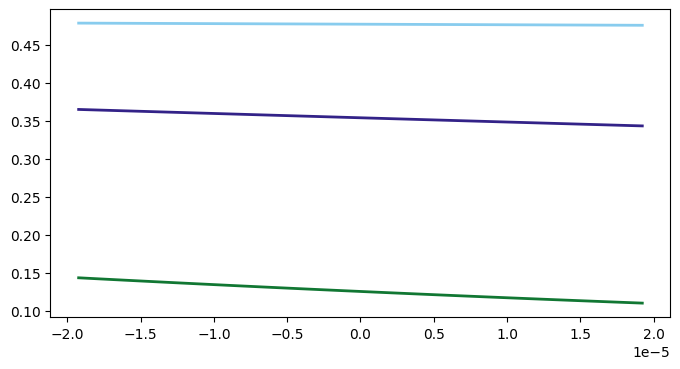

In [336]:
with open("data/Monte_carlo/tests/sample_500000_test1.json", "r") as f:
    data = json.load(f)
    
# Convert lists back into NumPy arrays
N_positions = data["N_positions"]
Ryd_classical_E = np.array(data["Ryd_classical_E"])
concentration = np.array(data["concentration"])

binary_vector_all = np.zeros((len(N_positions),num_sites), dtype='int')

for i,ones in enumerate(N_positions):
    # print(i,ones)
    binary_vector_all[i][ones] = 1   

# Plotting average concentration across detuning for each temperature
plt.figure(figsize=(8, 4))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE"]
Delta_mu_range = np.linspace(-1.25e8,1.25e8,100,endpoint=True)
Delta_mu_range = np.array(Delta_mu_range)/eV_to_rad_s
# print(Delta_mu_range)
T_all = [10e-6*V_ratio]
T_all = [10,100,1000]
for idx, T in enumerate(T_all):
    av_conc_classical = []
    for Delta_mu in Delta_mu_range:
        print(Delta_mu,Delta_mu*V_ratio)
        # Calculate energy with detuning and get partition function
        energy_new = Ryd_classical_E + concentration * Delta_mu*V_ratio #TEST V_RATIO HERE
        Z, pi = get_partition_function(
            energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
        )
        av_conc_classical.append(np.sum(pi * concentration))
    
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(
        Delta_mu_range*V_ratio, 
        av_conc_classical / num_sites, 
        label=f'T = {T} K', 
        color=colorblind_friendly_colors[idx], 
        linewidth=2
    )

# # Enhancements
# plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
# plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
# plt.title(
#     'Average Concentration vs Chemical Potential at Different Temperatures', 
#     fontsize=16, fontweight='bold'
# )
# plt.legend(
#     title="Temperature (T)", fontsize=10, title_fontsize=13, loc='upper right'
# )
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

### TEST 2 p 165

In [337]:
reg_coef[1]

np.float64(0.00020350836925458785)

In [ ]:
# Write config-energies
structure = copy.deepcopy(graphene_mol_r_6_6)
size = 500000
neighbor_count = [3,6,3]
scaling_factors = [0,1,1/27,1/343] # I need the zero, otherwise the 1 is assigned to the diagonal
binary_vector_all = []
Ryd_classical_E = []
concentration = []
N_positions = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites
# max_conc = 40

T_all = [10]

concentration = np.random.randint(0, max_conc, size=size)

# global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x.tolist())
    N_positions.append(ones.tolist())

Ryd_classical_E = calculate_Ryd_energy_mol(
    structure, binary_vector_all, [0.,(C6/(4.1e-6**6))/eV_to_rad_s], scaling_factors
)


data = {
    "N_positions": N_positions,
    "Ryd_classical_E": Ryd_classical_E.tolist(),
    "concentration": concentration.tolist()
}

# Write to a JSON file
with open("data/Monte_carlo/tests/sample_500000_test2.json", "w") as f:
    json.dump(data, f, indent=4)

In [435]:
energy_new

array([6.89302674e-06, 9.59796223e-06, 5.10248348e-06, ...,
       4.15323784e-07, 7.16645998e-07, 4.93138186e-06], shape=(500000,))

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:29: RuntimeWarning: overflow encountered in exp
  p_i = multiplicity * np.exp(exponent)
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:35: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


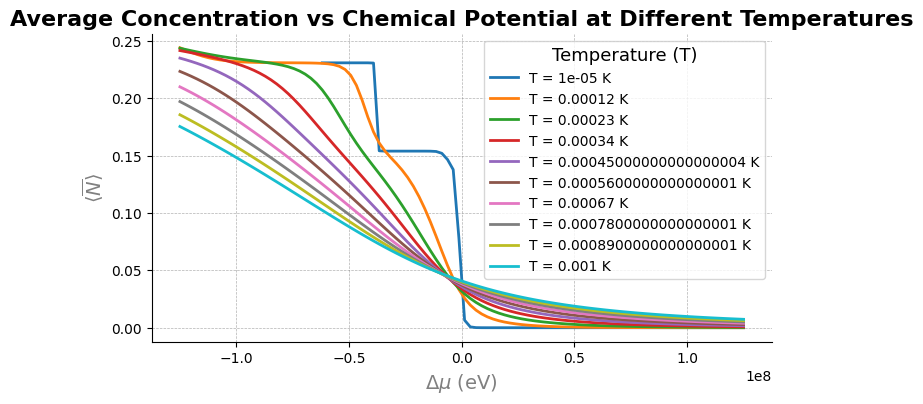

In [441]:
with open("data/Monte_carlo/tests/sample_500000_test2.json", "r") as f:
    data = json.load(f)
    
# Convert lists back into NumPy arrays
N_positions = data["N_positions"]
Ryd_classical_E = np.array(data["Ryd_classical_E"])
concentration = np.array(data["concentration"])

binary_vector_all = np.zeros((len(N_positions),num_sites), dtype='int')

for i,ones in enumerate(N_positions):
    # print(i,ones)
    binary_vector_all[i][ones] = 1   

# Plotting average concentration across detuning for each temperature
plt.figure(figsize=(8, 4))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE"]
Delta_mu_range = np.linspace(-1.25e8,1.25e8,100,endpoint=True)
Delta_mu_range = np.array(Delta_mu_range)/eV_to_rad_s
# print(Delta_mu_range)
T_all = [0.1e-6*V_ratio,1e-6*V_ratio,10e-6*V_ratio,100e-6*V_ratio]
T_all = [1e-6*V_ratio]
T_all = [1e-6,10e-6,1e-6*V_ratio,5e-6*V_ratio,10e-6*V_ratio]
T_all = np.linspace(1e-5,1e-3,10,endpoint=True)
# T_all = [10e-6]
# T_all = [100e-6]
# T_all = [10,100,1000]
for idx, T in enumerate(T_all):
    av_conc_classical = []
    for Delta_mu in Delta_mu_range:
        # print(Delta_mu,Delta_mu*V_ratio)
        # Calculate energy with detuning and get partition function
        energy_new = Ryd_classical_E + concentration * Delta_mu+concentration * Delta_mu*(1/V_ratio) #TEST V_RATIO HERE
        Z, pi = get_partition_function(
            energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
        )
        av_conc_classical.append(np.sum(pi * concentration))
    
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(
        Delta_mu_range*eV_to_rad_s, 
        av_conc_classical / num_sites, 
        label=f'T = {T} K', 
        # color=colorblind_friendly_colors[idx], 
        linewidth=2
    )

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    'Average Concentration vs Chemical Potential at Different Temperatures', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Temperature (T)", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.show()

In [364]:
# Prepare data
x_data = Delta_mu_range * eV_to_rad_s
y_data = av_conc_classical / num_sites

# Create a DataFrame
df = pd.DataFrame({
    'Delta_mu (rad/s)': x_data,
    'Average_conc': y_data
})

# Save to CSV
df.to_csv('data/Monte_carlo/average_conc_Boltzmann_hardware_1K_Vr.csv', index=False)

## Plot Hardware Energy

I am using the R=4um and 0 Delta_g

In [368]:
C6

5.42e-24

In [ ]:
# Write config-energies
structure = copy.deepcopy(graphene_mol_r_6_6)
# Delta_mu_range = np.linspace(-reg_coef[0]*2,0,100)
size = 1000000
neighbor_count = [3,6,3]
scaling_factors = [1,1/27,1/343]
binary_vector_all = []
Ryd_classical_E = []
concentration = []
N_positions = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites

# T_all = [10]

concentration = np.random.randint(0, max_conc, size=size)

# global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x.tolist())
    N_positions.append(ones.tolist())

Ryd_classical_E = calculate_Ryd_energy_pbc(
    # structure, binary_vector_all, [0.,7.510219121884898e-07], neighbor_count, scaling_factors
    structure, binary_vector_all, [0,1.2891318269e-6], neighbor_count, scaling_factors
)

data = {
    "N_positions": N_positions,
    "Ryd_classical_E": Ryd_classical_E.tolist(),
    "concentration": concentration.tolist()
}

# Write to a JSON file
with open("data/Monte_carlo/sample_1000000_R_4.1um.json", "w") as f:
    json.dump(data, f, indent=4)

In [321]:
Ryd_classical_E

array([5.91442934e-06, 4.21292395e-05, 1.45320023e-05, ...,
       1.07462388e-05, 2.78156264e-08, 4.58803754e-06], shape=(1000000,))

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:29: RuntimeWarning: overflow encountered in exp
  p_i = multiplicity * np.exp(exponent)
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:35: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


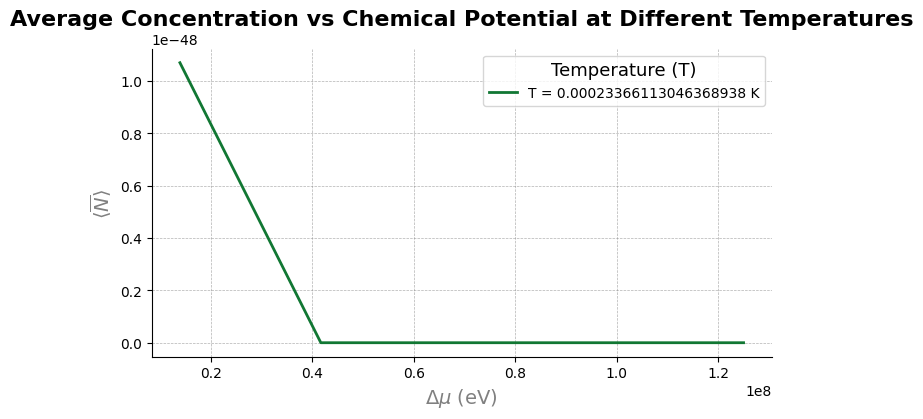

In [367]:
with open("data/Monte_carlo/sample_1000000_R_4um.json", "r") as f:
    data = json.load(f)
    
# Convert lists back into NumPy arrays
N_positions = data["N_positions"]
Ryd_classical_E = np.array(data["Ryd_classical_E"])
concentration = np.array(data["concentration"])

binary_vector_all = np.zeros((len(N_positions),num_sites), dtype='int')

for i,ones in enumerate(N_positions):
    # print(i,ones)
    binary_vector_all[i][ones] = 1   

# Plotting average concentration across detuning for each temperature
plt.figure(figsize=(8, 4))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE"]
# Delta_mu_range = np.linspace(-reg_coef[0]*2,0,100
Delta_mu_range = (np.linspace(-1.25e8,1.25e8,10,endpoint=True)/eV_to_rad_s)#*V_ratio
T_all = [1e-6*V_ratio]

for idx, T in enumerate(T_all):
    av_conc_classical = []
    for Delta_mu in Delta_mu_range:
        # Calculate energy with detuning and get partition function
        energy_new = Ryd_classical_E + concentration * Delta_mu*V_ratio
        Z, pi = get_partition_function(
            energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
        )
        av_conc_classical.append(np.sum(pi * concentration))
    
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(
        Delta_mu_range*eV_to_rad_s, 
        av_conc_classical / num_sites, 
        label=f'T = {T} K', 
        color=colorblind_friendly_colors[idx], 
        linewidth=2
    )

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    'Average Concentration vs Chemical Potential at Different Temperatures', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Temperature (T)", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

In [282]:

# Prepare data
x_data = Delta_mu_range * eV_to_rad_s
y_data = av_conc_classical / num_sites

# Create a DataFrame
df = pd.DataFrame({
    'Delta_mu (rad/s)': x_data,
    'Average_conc': y_data
})

# Save to CSV
df.to_csv('data/Monte_carlo/average_conc_Boltzmann_1K_Vr.csv', index=False)

In [256]:
av_conc_classical / num_sites

array([2.17960648e-01, 2.17948720e-01, 2.17815311e-01, 1.53848156e-01,
       1.49536274e-01, 1.72602087e-03, 2.28062363e-05, 3.27097302e-07,
       4.69674357e-09, 6.74409787e-11])

### Gaussian concentration plots

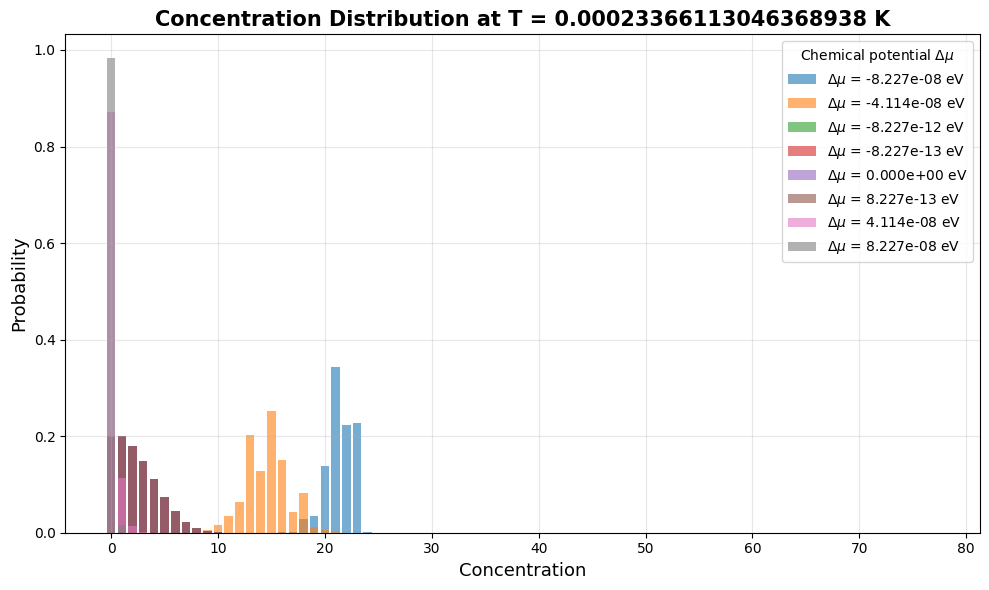

In [294]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load data
with open("data/Monte_carlo/sample_1000000_R_4um.json", "r") as f:
    data = json.load(f)

N_positions = data["N_positions"]
Ryd_classical_E = np.array(data["Ryd_classical_E"])
concentration = np.array(data["concentration"])
num_sites = graphene_mol_r_6_6.num_sites  # or use graphene_mol_r_6_6.num_sites if available

# Reconstruct binary vectors if needed
binary_vector_all = np.zeros((len(N_positions), num_sites), dtype=int)
for i, ones in enumerate(N_positions):
    binary_vector_all[i][ones] = 1

# Parameters
Delta_mu_range = np.linspace(-reg_coef[0]*2,0,5)
Delta_mu_range = np.array(Delta_mu_all)/eV_to_rad_s
Delta_mu_range = np.array([-125000000,-62500000,-12500,-1250,0,1250,62500000,125000000])/eV_to_rad_s
unique_concentrations = np.unique(concentration)

plt.figure(figsize=(10, 6))
T = 1e-6*V_ratio
for idx, Delta_mu in enumerate(Delta_mu_range):
    # Adjust energy with Delta_mu
    energy_new = Ryd_classical_E + concentration * Delta_mu

    # Compute Boltzmann weights
    Z, pi = get_partition_function(
        energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
    )

    # Compute average probability per concentration value
    prob_by_conc = []
    for c in unique_concentrations:
        mask = concentration == c
        prob_by_conc.append(np.sum(pi[mask]))

    # Bar plot (semi-transparent for overlay)
    plt.bar(
        unique_concentrations,
        prob_by_conc,
        width=0.8,
        alpha=0.6,
        label=rf"$\Delta \mu$ = {Delta_mu:.3e} eV"
    )

# Labels and styles
plt.xlabel("Concentration", fontsize=13)
plt.ylabel("Probability", fontsize=13)
plt.title(f"Concentration Distribution at T = {T} K", fontsize=15, fontweight="bold")
plt.legend(title=r"Chemical potential $\Delta \mu$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [293]:
import pandas as pd

# Create a DataFrame to store the results
df = pd.DataFrame({'Concentration': unique_concentrations})

# Re-run the loop, saving data as we go
for idx, Delta_mu in enumerate(Delta_mu_range):
    energy_new = Ryd_classical_E + concentration * Delta_mu
    Z, pi = get_partition_function(energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T)

    # Compute probabilities by concentration
    prob_by_conc = []
    for c in unique_concentrations:
        mask = concentration == c
        prob_by_conc.append(np.sum(pi[mask]))

    # Add to DataFrame with a readable column name
    df[f"{Delta_mu:.2e} eV"] = prob_by_conc

# Save to CSV
df.to_csv("data/Monte_carlo/concentration_distribution_vs_Delta_mu_10K.csv", index=False)
print("Saved to concentration_distribution_vs_Delta_mu.csv")

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:29: RuntimeWarning: overflow encountered in exp
  p_i = multiplicity * np.exp(exponent)
/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_44093/3331741997.py:35: RuntimeWarning: invalid value encountered in divide
  p_i /= pf


Saved to concentration_distribution_vs_Delta_mu.csv


## Gaussians fixed Delta mu, varying T

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load data
with open("data/Monte_carlo/sample_100000.json", "r") as f:
    data = json.load(f)

N_positions = data["N_positions"]
Ryd_classical_E = np.array(data["Ryd_classical_E"])
concentration = np.array(data["concentration"])
num_sites = graphene_mol_r_6_6.num_sites

# Reconstruct binary vectors if needed
binary_vector_all = np.zeros((len(N_positions), num_sites), dtype=int)
for i, ones in enumerate(N_positions):
    binary_vector_all[i][ones] = 1

# Parameters
Delta_mu = -0.1  # <-- fixed chemical potential
T_all = [1, 5, 10, 50]  # try different T values

unique_concentrations = np.unique(concentration)

plt.figure(figsize=(10, 6))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE", "#CC6677"]

for idx, T in enumerate(T_all):
    # Shift energy with fixed Delta_mu
    energy_new = Ryd_classical_E + concentration * Delta_mu

    # Get partition function and Boltzmann weights
    Z, pi = get_partition_function(
        energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
    )

    # Average probability per concentration
    prob_by_conc = []
    for c in unique_concentrations:
        mask = concentration == c
        prob_by_conc.append(np.sum(pi[mask]))

    # Bar plot overlay
    plt.bar(
        unique_concentrations,
        prob_by_conc,
        width=0.8,
        alpha=0.6,
        label=f"T = {T} K",
        color=colorblind_friendly_colors[idx % len(colorblind_friendly_colors)]
    )

# Labels and styles
plt.xlabel("Concentration", fontsize=13)
plt.ylabel("Probability", fontsize=13)
plt.title(rf"Concentration Distribution at $\Delta \mu$ = {Delta_mu:.2f} eV", fontsize=15, fontweight="bold")
plt.legend(title="Temperature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Average concentration pbc

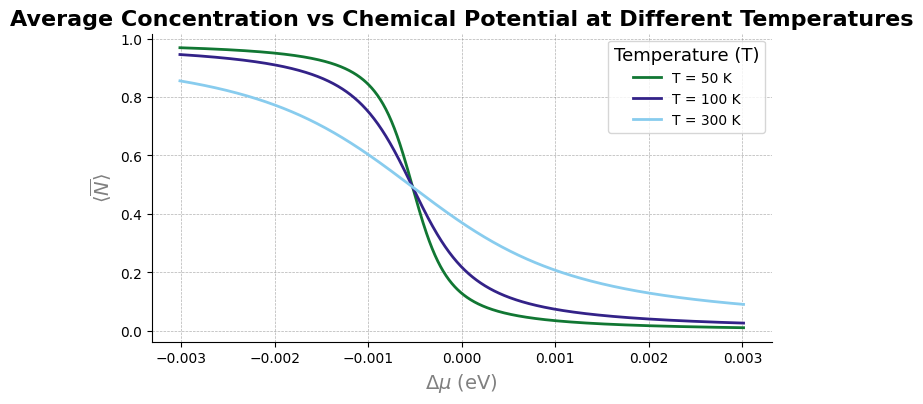

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Assume necessary functions and objects are defined

structure = copy.deepcopy(graphene_mol_r_6_6_pbc)

size = 100000
binary_vector_all = []
Ryd_classical_E = []
concentration = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites

T_all = [50, 100, 300]

concentration = np.random.randint(0, max_conc, size=size)

global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)

Ryd_classical_E = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, reg_coef, neighbor_count, scaling_factors
)

# Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)
Ryd_classical_E = np.array(Ryd_classical_E)
concentration = np.array(concentration)

# Plotting average concentration across detuning for each temperature
plt.figure(figsize=(8, 4))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE"]

for idx, T in enumerate(T_all):
    av_conc_classical = []
    for glob_det in global_detuning_range:
        # Calculate energy with detuning and get partition function
        energy_new = Ryd_classical_E + concentration * glob_det
        Z, pi = get_partition_function(
            energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
        )
        av_conc_classical.append(np.sum(pi * concentration))
    
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(
        global_detuning_range, 
        av_conc_classical / num_sites, 
        label=f'T = {T} K', 
        color=colorblind_friendly_colors[idx], 
        linewidth=2
    )

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    'Average Concentration vs Chemical Potential at Different Temperatures', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Temperature (T)", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

### Average concentration comapre pbc-mol

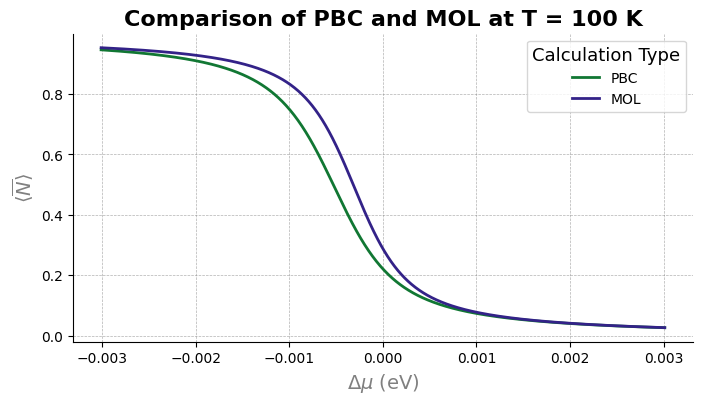

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Assume necessary functions and objects are defined

structure = copy.deepcopy(graphene_mol_r_6_6_pbc)

size = 10000
binary_vector_all = []
concentration = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites
T_all = [50, 100, 300]

# Randomly generate concentrations
concentration = np.random.randint(0, max_conc, size=size)

# Define global detuning range
global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)

# Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)
concentration = np.array(concentration)

# --- New Graph Comparing PBC and MOL ---

# Choose one temperature for comparison
T = 100  # Example: Choose T = 100 K

# Calculate energies using calculate_Ryd_energy_pbc
Ryd_classical_E_pbc = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, reg_coef, neighbor_count, scaling_factors
)

# Calculate energies using calculate_Ryd_energy_mol
Ryd_classical_E_mol = calculate_Ryd_energy_mol(
    structure, binary_vector_all, reg_coef, scaling_factors
)

# Prepare for plotting
av_conc_pbc = []
av_conc_mol = []

for glob_det in global_detuning_range:
    # Energy and partition function for PBC
    energy_pbc = Ryd_classical_E_pbc + concentration * glob_det
    Z_pbc, pi_pbc = get_partition_function(
        energy_pbc, [1] * len(Ryd_classical_E_pbc), return_pi=True, T=T
    )
    av_conc_pbc.append(np.sum(pi_pbc * concentration))
    
    # Energy and partition function for MOL
    energy_mol = Ryd_classical_E_mol + concentration * glob_det
    Z_mol, pi_mol = get_partition_function(
        energy_mol, [1] * len(Ryd_classical_E_mol), return_pi=True, T=T
    )
    av_conc_mol.append(np.sum(pi_mol * concentration))

# Convert to NumPy arrays
av_conc_pbc = np.array(av_conc_pbc) / num_sites
av_conc_mol = np.array(av_conc_mol) / num_sites

# Plot the results
plt.figure(figsize=(8, 4))

plt.plot(
    global_detuning_range, av_conc_pbc, label='PBC', color='#117733', linewidth=2
)
plt.plot(
    global_detuning_range, av_conc_mol, label='MOL', color='#332288', linewidth=2
)

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    f'Comparison of PBC and MOL at T = {T} K', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Calculation Type", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

### Cell within

In [358]:
external_indices = np.array([0,39,1,41,4,45,32,73,36,76,38,77,40,3,44,8,
                    50,14,56,20,62,26,68,9,51,15,57,21,63,27,69,33,74,37])
graphene_mol_r_6_6_inside = copy.deepcopy(graphene_mol_r_6_6_pbc)

graphene_mol_r_6_6_inside.remove_sites(external_indices)
vview(graphene_mol_r_6_6_inside)


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [356]:
binary_vector_all

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 1]], shape=(10000, 78))

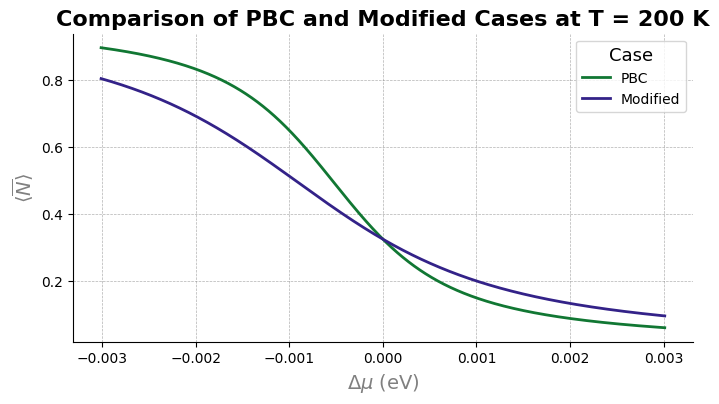

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Assume necessary functions and objects are defined (e.g., calculate_Ryd_energy_pbc, calculate_Ryd_energy_mol, get_partition_function)

# Copy the structure
structure = copy.deepcopy(graphene_mol_r_6_6_pbc)

# Parameters
size = 10000
num_sites = graphene_mol_r_6_6.num_sites
num_sites_modified = num_sites-len(external_indices)
max_conc = graphene_mol_r_6_6.num_sites
T = 200  # Set temperature for comparison


# Randomly generate binary vectors and concentrations
binary_vector_all = []
concentration = np.random.randint(0, max_conc, size=size)

for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)

# Convert binary vectors and concentration to numpy arrays
binary_vector_all = np.array(binary_vector_all)
concentration = np.array(concentration)

# Define global detuning range
global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Calculate energies for PBC
Ryd_classical_E_pbc = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, reg_coef, neighbor_count, scaling_factors
)

# Adjust concentration for the modified case by excluding `external_indices`
concentration_modified = np.array([
    np.sum(np.delete(x, external_indices)) for x in np.array(binary_vector_all)
])

# Initialize lists for average compositions
av_conc_pbc = []
av_conc_modified = []

# Compute average composition for PBC and modified cases across the detuning range
for glob_det in global_detuning_range:
    # PBC case
    energy_pbc = Ryd_classical_E_pbc + concentration * glob_det
    Z_pbc, pi_pbc = get_partition_function(
        energy_pbc, [1] * len(Ryd_classical_E_pbc), return_pi=True, T=T
    )
    av_conc_pbc.append(np.sum(pi_pbc * concentration))
    
    # Modified case
    energy_modified = Ryd_classical_E_pbc + concentration_modified * glob_det
    Z_modified, pi_modified = get_partition_function(
        energy_modified, [1] * len(Ryd_classical_E_pbc), return_pi=True, T=T
    )
    av_conc_modified.append(np.sum(pi_modified * concentration_modified))

# Convert results to numpy arrays and normalize
av_conc_pbc = np.array(av_conc_pbc) / num_sites
av_conc_modified = np.array(av_conc_modified) / num_sites_modified 

# Plot the results
plt.figure(figsize=(8, 4))

plt.plot(
    global_detuning_range, av_conc_pbc, label='PBC', color='#117733', linewidth=2
)
plt.plot(
    global_detuning_range, av_conc_modified, label='Modified', color='#332288', linewidth=2
)

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    f'Comparison of PBC and Center Only at T = {T} K', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Case", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()